In [3]:
### CREATION DES ECHANTILLONS DE REFERENCE

import time as cl
import random as rd
import numpy as np
import pickle

def GenPermutation(n):  # Création d'une permutation de [0,1,2, ..., n-1]
    L1 = list(range(n))
    L = []
    m = n
    for k in range(n):
        nouv = rd.randint(0,m-1)
        m -= 1
        L.append(L1.pop(nouv))
    return L
    

def PartitionHomogene(X,ident,p):   
# Utiliser la fonction VectorisationAmb pour avoir X et ident
    deb = 0
    nX = []
    nY = []
    nXn = []
    nYn = []
    n = 0
    for couple in ident:
        nbTextes = couple[1]
        TailleSample = int(nbTextes * p)
        L = GenPermutation(nbTextes)
        
        for k in range(TailleSample):
            nX.append(X[ deb+L[k] ])
            nY.append(n)
        
        
        for k in range(TailleSample,nbTextes):
            nXn.append(X[ deb + L[k] ])
            nYn.append(n)
        
        deb += nbTextes
        n+=1
    return nX, nY, nXn, nYn
    
    
def GenEchantillons(n,p,Xt,ident):
    Xtot = []        
    c1=cl.clock()
    
    for k in range(n):
        nX,nY,nXn,nYn = PartitionHomogene(Xt,ident,p)
        Xtot.append((nX,nY,nXn,nYn))
    c2=cl.clock()
    print(c2-c1)
        
    return Xtot
    
def GenGamme(n,pas):
    Interv = np.linspace(0,1,pas)

    Banque=[]
      
    response = VectorisationAmb()
    Vec,ident = response
    X = []
    for vec in Vec:
        X.append(list(vec))
    Y = []

    for k in range(len(ident)):
        for i in range(ident[k][1]):
            Y.append(k)
    dim = 30
    Xt,pca = ReductionDim(X,dim)
    xt = []
    for a in Xt:
        xt.append(list(a))
    Xt = xt
    
    for p in Interv[1:(pas-1)]:
        Banque.append(GenEchantillons(n,p,Xt,ident))
    
    return Banque
        
##Banque = GenGamme(20,11)


def moyenne(X):
    n = len(X)
    tot = 0
    for x in X:
        tot+=x
    moy = tot/n
    variance = 0
    for x in X:
        elem = (moy-x)**2
        variance += elem/n
    ecartType = variance*(1/2)
    incertitude = ecartType/(n**(1/2))
    return moy,incertitude
    
    
# Extraction d'un fichier binaire
def readbinary(adresse):
        
    with open(adresse, "rb") as file:
        s = file.read()
    return s
    
def register(Banque,direction):
    serialBanque = pickle.dumps(Banque)
    
    
    fichiertxt = open(direction,mode="xb")
    fichiertxt.write(serialBanque)
    fichiertxt.close()

def recuperation(direction):
    c1 = cl.clock()

    serial_Banque= readbinary(direction)
    
    Banque= pickle.loads(serial_Banque)
    c2 = cl.clock()
    print(c2-c1)
    return Banque


##Banque = recuperation("Banque")

In [4]:
KNNRes = recuperation("/Users/NAIT/classification/pact35/modules/Classification/src/KNN/Résultats/KNN")

0.0020329999999999515


In [5]:
from sklearn.neighbors import KNeighborsClassifier
import random as rd
import pylab as pl

def entraineKNN(nX,nY,n):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(nX,nY)
    return model


def testKNN(nX, nY, nXn, nYn, k):
    #nX et nY les parties d'entraînement
    #nXn et nYn les parties de testKNN
    # k est le nombre de proches voisins
    model = entraineKNN(nX,nY,k)
    n = len(nXn)
    if n == 0:
        return -1
    goal = 0
    failure = 0
    
    for i in range(n):
        prediction = model.predict([nXn[i]])
        if prediction[0] == nYn[i]:
            goal+=1
        else:
            failure +=1
    return goal/n


def efficKNNpara(Banque):
    p0 = 0
    p1 = 1
    pas = 11
    P = np.linspace(0,1,11)
    P = list(P)
    P = P[1:10]
    K = []
    AbscisseP = []
    
    for k in range(22):
        n_components = 2*k+1
        K.append(n_components)
    
    for i in range(len(P)):             # Proportion prise dans la bibliohèque
        p = P[i]
        EnsemblePartitionP = Banque[i]
        AbscisseNComponents = []
        
        for k in range(22): # n_components variation
            c1 = cl.clock()
            n_components = 2*k + 1
            Z = []
            for (nX, nY, nXn, nYn) in EnsemblePartitionP:
                zi = testKNN(nX, nY, nXn, nYn, n_components)
                Z.append(zi)
            z,incertitude = moyenne(Z)
            AbscisseNComponents.append((z,incertitude))
            c2 = cl.clock()
            print("Pour n_components = " + str(n_components) + " et p = " + str(p) + " on a mis un temps: " + str(c2-c1))
        AbscisseP.append(AbscisseNComponents)
                
    
    return AbscisseP,P,K
                

########################################################################################################################################

def efficKNN(X,ident,p0,p1,pas,iteration):
    abs = np.linspace(p0,p1,pas)
    
    # On enlève les cas triviaux pathologiques 0 et 1
    if p0 == 0:
        abs = abs[1:]    
    if p1 == 1:
        abs = abs[:(pas-2)]
    res = []
    
    for p in abs:
        c1 = cl.clock()
        T=[]
        for k in range(iteration):
            nX, nY, nXn, nYn = PartitionHomogene(X,ident,p)
            T.append(testKNN(nX, nY, nXn, nYn))
        res.append(moyenne(T))
        c2 = cl.clock()
        print("Pour la proportion p = ", p , ", on met un temps de ", (c2-c1) ," secondes")
    ResP = []
    ResM = []
    for couple in res:
        ResM.append(couple[0]-couple[1])
        ResP.append(couple[0]+couple[1])
    pl.plot(abs,ResP)
    pl.plot(abs,ResM)
    pl.show()
    return abs,res



#P=[0.10000000000000001, 0.20000000000000001, 0.30000000000000004, 0.40000000000000002, 0.5, 0.59999999999999998, 0.70000000000000007, 0.80000000000000004, 0.90000000000000002]
#K=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43]
#Z=[[(0.19713386348575213, 8.133905069254739e-06), (0.18316766070245197, 1.2043601308010642e-05), (0.20226971504307492, 6.7014289464563785e-06), (0.21194499668654734, 6.671723786069301e-06), (0.21494367130550032, 9.176807833464305e-06), (0.21491053677932404, 9.31710947942476e-06), (0.2140159045725646, 1.0192920716456996e-05), (0.21472829688535455, 1.1545088569903111e-05), (0.21449635520212057, 1.4582870839570111e-05), (0.21245858184227967, 1.5662229936981985e-05), (0.2116467859509609, 1.58945623432739e-05), (0.21174618952948973, 1.6704212086716754e-05), (0.209973492379059, 2.010020544853082e-05), (0.20758780649436717, 2.303316041666655e-05), (0.20611332007952288, 2.4250795808194323e-05), (0.20463883366467858, 2.6041605771736403e-05), (0.20311464546056995, 2.4482207600011428e-05), (0.20213717693836983, 2.7766315615987387e-05), (0.19971835652750164, 3.315056005904028e-05),(0.1975480450629556, 3.226029517475361e-05), (0.19597415506958252, 3.074419657049368e-05), (0.19441683233929757, 3.232323451768117e-05)], [(0.21181073025335317, 3.2599629883900427e-06), (0.20586810730253352, 4.639646681607865e-06), (0.231371087928465, 6.093127680275794e-06), (0.24267883755588668, 3.3465254428901374e-06), (0.24793219076005965, 4.515487177170253e-06), (0.2501490312965723, 6.402595245086546e-06), (0.25141579731743663, 6.690024497859617e-06), (0.2538561847988078, 5.263237792645767e-06), (0.2548062593144561, 4.2693797594678156e-06), (0.255849478390462, 4.449721439663463e-06), (0.2570044709388971, 4.650704637471835e-06),(0.2561102831594635, 6.045636669828411e-06), (0.2541356184798808, 9.70446206622428e-06), (0.25326005961251863, 8.25330905826455e-06), (0.2529806259314456, 1.0516310025865712e-05), (0.2523099850968703, 1.1102342886811241e-05), (0.2525521609538003, 1.2217722034957487e-05), (0.2524031296572279, 1.2405823684180486e-05), (0.2513785394932936, 1.1137262747434316e-05), (0.24999999999999994, 1.0836020749792566e-05), (0.24806259314456036, 1.1361525852324748e-05), (0.24662816691505213,1.2241312340800656e-05)], [(0.2206507868991919, 4.4943756681793795e-06), (0.22033177371331356, 5.020552645140353e-06), (0.24629944704381118, 5.440229986014838e-06), (0.2586771586558911, 8.435570178167877e-06), (0.26533390046788596, 7.884007248065683e-06), (0.2687579753296469, 5.6299672294129725e-06), (0.27071458953636746, 7.802842995492667e-06), (0.27320289238621853, 6.195993073057773e-06), (0.2751807741386643, 8.021303787464924e-06), (0.2744789451297319, 6.901945076745923e-06), (0.2750106337728625, 6.399030128559771e-06), (0.276393024245002, 6.302189291377626e-06), (0.2764993619736282, 5.055900814952529e-06), (0.2764568268821777, 5.693078124871632e-06), (0.2776478094427902, 3.940132547805299e-06), (0.27792428753721815, 5.557399813561077e-06), (0.27728626116546146, 4.061550224084335e-06),(0.2774989366227137, 3.95333122065363e-06), (0.27588260314759666, 3.4476349429400504e-06), (0.2751382390472139, 3.378607401032153e-06), (0.27558485750744355, 2.6456006464863245e-06), (0.27522330923011473, 2.1087029084378235e-06)], [(0.22353670634920633, 5.202698186514225e-06), (0.22673611111111117, 8.46972938703185e-06), (0.2553323412698413, 7.165736573790823e-06), (0.2665426587301587, 7.76928284925115e-06), (0.2749007936507936, 6.458000165317464e-06), (0.278422619047619, 4.616276229945157e-06), (0.28157242063492066, 5.623585060467868e-06), (0.2832341269841271, 4.632506508091089e-06), (0.2843998015873016, 5.30998307595339e-06), (0.2854662698412699, 5.915798839459545e-06), (0.2857638888888888, 8.28541944876457e-06), (0.2850446428571428, 5.60983058746285e-06), (0.28777281746031746, 5.398011703185521e-06), (0.28829365079365077, 5.993098977747754e-06), (0.2873511904761905, 8.583066244593233e-06), (0.28757440476190477, 7.223505360411905e-06), (0.28888888888888886, 5.85225317417634e-06), (0.28874007936507934, 7.616952060720539e-06), (0.2881944444444444, 5.633832142856609e-06), (0.28851686507936514, 6.316810499920925e-06), (0.28831845238095244, 5.44092565896119e-06), (0.2876488095238095,6.19749044660237e-06)], [(0.22221228384019082, 8.198519960321811e-06), (0.22829457364341085, 7.82482543545474e-06), (0.2590339892665474, 1.0973897515351905e-05), (0.2742993440667859, 8.113941758018127e-06), (0.2808586762075135, 7.342699866271169e-06), (0.28664281454979135, 7.1761275195485125e-06), (0.29054859868813365, 9.198749135391569e-06), (0.2928443649373882, 8.113544210651254e-06), (0.2955575432319618, 8.317784170385771e-06), (0.29534883720930233, 1.02690460338739e-05),(0.29680977936791886, 7.767578614624042e-06), (0.2980023852116876, 8.029959876764741e-06), (0.29749552772808585, 6.853319057642064e-06), (0.29603458556946927, 7.4519260053214185e-06), (0.29570661896243294, 7.62456094938901e-06), (0.29522957662492544, 4.5077895930508416e-06), (0.29600477042337514, 5.559302378448088e-06), (0.2961240310077519, 6.167549849774285e-06), (0.2966607036374478, 8.362408862318036e-06), (0.29686940966010733, 7.0456325963701975e-06), (0.2975849731663685,6.648880324224074e-06), (0.29698867024448417, 6.581297271854518e-06)], [(0.21973293768545993, 3.836907493376463e-06), (0.23126854599406527, 1.2606388454925755e-05), (0.2604228486646884, 7.632437175827719e-06), (0.2758531157270029, 8.443380741618326e-06), (0.28468100890207715, 1.188650683734229e-05), (0.29050445103857564, 1.177898605728014e-05), (0.2946958456973293, 7.610286972209773e-06), (0.296179525222552, 1.082206649681291e-05), (0.2996290801186943, 1.0939124170099441e-05), (0.30029673590504447, 1.1361823889142038e-05), (0.3019658753709199, 1.057349198954476e-05), (0.30263353115727, 1.0081265242479152e-05), (0.30192878338278933,7.05114815171493e-06), (0.3017062314540059, 8.460762498624067e-06), (0.2996661721068249, 8.986060730258159e-06), (0.2982195845697329, 9.204640170126985e-06), (0.29833086053412466, 7.495844253517018e-06), (0.30092729970326404, 6.49293225637083e-06), (0.3020771513353115, 1.0506579916115533e-05), (0.30126112759643914, 6.35526258805091e-06), (0.30152077151335316, 9.644414004458418e-06), (0.30048219584569735, 1.0062806739464192e-05)], [(0.21691248770894794, 6.879284517580999e-06), (0.23121927236971485, 9.288493406417992e-06), (0.25835791543756154, 1.2127117093276518e-05), (0.27841691248770895, 1.0899136701703287e-05), (0.2861848574237955, 1.3225381246303271e-05), (0.2926253687315634, 1.280299274453635e-05), (0.2976892822025566, 1.2775698286008848e-05), (0.3021140609636185, 8.570730219794192e-06), (0.3037364798426745, 8.72233607359539e-06), (0.3071779744346116, 1.0705913554701771e-05), (0.3088987217305802, 1.4844672290825022e-05), (0.30899705014749257, 1.2743269226372238e-05), (0.3086037364798426, 1.127747573079716e-05), (0.30968534906588, 9.917617163368367e-06), (0.30968534906588, 7.69082173498733e-06), (0.3087512291052114, 9.317949802254596e-06), (0.30806293018682396, 7.092235342528107e-06), (0.30791543756145523, 7.5373241860406975e-06), (0.3081612586037365, 1.0738342614338402e-05), (0.30757128810226153, 1.1951189444747873e-05), (0.308062930186824, 9.5027954421833e-06), (0.3083579154375614, 9.041221826688781e-06)], [(0.21375000000000005, 1.1153138584788227e-05), (0.23014705882352943, 1.480959814250238e-05), (0.26330882352941176, 1.4881530476337411e-05), (0.27794117647058825, 1.133992086340182e-05), (0.2913970588235294, 1.1443285813702553e-05), (0.299485294117647, 1.7850703785560747e-05), (0.30294117647058816, 2.2002831526003557e-05),(0.304264705882353, 2.2145487246886426e-05), (0.30727941176470586, 1.6743308528537698e-05), (0.31029411764705883, 1.373363550194509e-05), (0.3144852941176471, 1.4054610873931546e-05), (0.3166176470588236, 1.4969179118405275e-05), (0.3168382352941177, 1.4277057082765885e-05), (0.3170588235294118, 1.3428980911585025e-05), (0.3166911764705882, 1.9905913323703925e-05), (0.3171323529411765, 2.2976638163047276e-05), (0.3154411764705883, 2.2571036515960782e-05), (0.31617647058823534, 2.4372367228803935e-05), (0.3141176470588235, 2.2447723943672195e-05), (0.314264705882353, 2.0844660503920505e-05), (0.3150735294117647, 2.1733840865864212e-05), (0.3146323529411765, 1.795225531568077e-05)], [(0.20785714285714282, 4.1150495892049704e-05), (0.22114285714285717, 3.8551637293710667e-05), (0.26257142857142857, 2.362930609692634e-05), (0.27614285714285713, 5.661130876504824e-05), (0.2927142857142857, 5.699463470404822e-05), (0.30357142857142855, 5.411056335347702e-05), (0.3082857142857142, 5.000578142335242e-05), (0.3075714285714286, 5.761525765290529e-05), (0.31128571428571433, 5.051460097333452e-05), (0.3152857142857143, 3.452443323219317e-05), (0.31771428571428567, 2.8347865869854455e-05), (0.321, 4.1917147770049634e-05), (0.31999999999999995, 4.508643187285287e-05), (0.32228571428571434, 4.833557554628118e-05), (0.3222857142857143, 4.313329494556736e-05), (0.32599999999999996, 4.434716041906726e-05), (0.3225714285714285, 4.6720130517638465e-05), (0.32314285714285707, 4.288687112763881e-05), (0.32228571428571434, 4.5414996963424335e-05), (0.3218571428571428, 4.5750407160049295e-05), (0.32271428571428573, 5.215742642619151e-05), (0.32057142857142856, 4.523246080199575e-05)]]
#format de Z: liste de 9 listes de 22 couples de floats


### La fonction retourne une liste, notée KNNRes, qui est une liste de listes de couples comportant le taux de réussite et un calcul d'incertitude; ce pour chaque valeur de paramètre de voisins k; et ce pour chaque proportion p du DataTraining. À noter que ce classifieur est donc testé non seulement selon la proportion de DataTraining utilisé mais aussi du paramètre d'entrée du classifieur. 

In [2]:
KNNRes = [[(0.19713386348575213, 8.133905069254739e-06), (0.18316766070245197, 1.2043601308010642e-05), (0.20226971504307492, 6.7014289464563785e-06), (0.21194499668654734, 6.671723786069301e-06), (0.21494367130550032, 9.176807833464305e-06), (0.21491053677932404, 9.31710947942476e-06), (0.2140159045725646, 1.0192920716456996e-05), (0.21472829688535455, 1.1545088569903111e-05), (0.21449635520212057, 1.4582870839570111e-05), (0.21245858184227967, 1.5662229936981985e-05), (0.2116467859509609, 1.58945623432739e-05), (0.21174618952948973, 1.6704212086716754e-05), (0.209973492379059, 2.010020544853082e-05), (0.20758780649436717, 2.303316041666655e-05), (0.20611332007952288, 2.4250795808194323e-05), (0.20463883366467858, 2.6041605771736403e-05), (0.20311464546056995, 2.4482207600011428e-05), (0.20213717693836983, 2.7766315615987387e-05), (0.19971835652750164, 3.315056005904028e-05),(0.1975480450629556, 3.226029517475361e-05), (0.19597415506958252, 3.074419657049368e-05), (0.19441683233929757, 3.232323451768117e-05)], [(0.21181073025335317, 3.2599629883900427e-06), (0.20586810730253352, 4.639646681607865e-06), (0.231371087928465, 6.093127680275794e-06), (0.24267883755588668, 3.3465254428901374e-06), (0.24793219076005965, 4.515487177170253e-06), (0.2501490312965723, 6.402595245086546e-06), (0.25141579731743663, 6.690024497859617e-06), (0.2538561847988078, 5.263237792645767e-06), (0.2548062593144561, 4.2693797594678156e-06), (0.255849478390462, 4.449721439663463e-06), (0.2570044709388971, 4.650704637471835e-06),(0.2561102831594635, 6.045636669828411e-06), (0.2541356184798808, 9.70446206622428e-06), (0.25326005961251863, 8.25330905826455e-06), (0.2529806259314456, 1.0516310025865712e-05), (0.2523099850968703, 1.1102342886811241e-05), (0.2525521609538003, 1.2217722034957487e-05), (0.2524031296572279, 1.2405823684180486e-05), (0.2513785394932936, 1.1137262747434316e-05), (0.24999999999999994, 1.0836020749792566e-05), (0.24806259314456036, 1.1361525852324748e-05), (0.24662816691505213,1.2241312340800656e-05)], [(0.2206507868991919, 4.4943756681793795e-06), (0.22033177371331356, 5.020552645140353e-06), (0.24629944704381118, 5.440229986014838e-06), (0.2586771586558911, 8.435570178167877e-06), (0.26533390046788596, 7.884007248065683e-06), (0.2687579753296469, 5.6299672294129725e-06), (0.27071458953636746, 7.802842995492667e-06), (0.27320289238621853, 6.195993073057773e-06), (0.2751807741386643, 8.021303787464924e-06), (0.2744789451297319, 6.901945076745923e-06), (0.2750106337728625, 6.399030128559771e-06), (0.276393024245002, 6.302189291377626e-06), (0.2764993619736282, 5.055900814952529e-06), (0.2764568268821777, 5.693078124871632e-06), (0.2776478094427902, 3.940132547805299e-06), (0.27792428753721815, 5.557399813561077e-06), (0.27728626116546146, 4.061550224084335e-06),(0.2774989366227137, 3.95333122065363e-06), (0.27588260314759666, 3.4476349429400504e-06), (0.2751382390472139, 3.378607401032153e-06), (0.27558485750744355, 2.6456006464863245e-06), (0.27522330923011473, 2.1087029084378235e-06)], [(0.22353670634920633, 5.202698186514225e-06), (0.22673611111111117, 8.46972938703185e-06), (0.2553323412698413, 7.165736573790823e-06), (0.2665426587301587, 7.76928284925115e-06), (0.2749007936507936, 6.458000165317464e-06), (0.278422619047619, 4.616276229945157e-06), (0.28157242063492066, 5.623585060467868e-06), (0.2832341269841271, 4.632506508091089e-06), (0.2843998015873016, 5.30998307595339e-06), (0.2854662698412699, 5.915798839459545e-06), (0.2857638888888888, 8.28541944876457e-06), (0.2850446428571428, 5.60983058746285e-06), (0.28777281746031746, 5.398011703185521e-06), (0.28829365079365077, 5.993098977747754e-06), (0.2873511904761905, 8.583066244593233e-06), (0.28757440476190477, 7.223505360411905e-06), (0.28888888888888886, 5.85225317417634e-06), (0.28874007936507934, 7.616952060720539e-06), (0.2881944444444444, 5.633832142856609e-06), (0.28851686507936514, 6.316810499920925e-06), (0.28831845238095244, 5.44092565896119e-06), (0.2876488095238095,6.19749044660237e-06)], [(0.22221228384019082, 8.198519960321811e-06), (0.22829457364341085, 7.82482543545474e-06), (0.2590339892665474, 1.0973897515351905e-05), (0.2742993440667859, 8.113941758018127e-06), (0.2808586762075135, 7.342699866271169e-06), (0.28664281454979135, 7.1761275195485125e-06), (0.29054859868813365, 9.198749135391569e-06), (0.2928443649373882, 8.113544210651254e-06), (0.2955575432319618, 8.317784170385771e-06), (0.29534883720930233, 1.02690460338739e-05),(0.29680977936791886, 7.767578614624042e-06), (0.2980023852116876, 8.029959876764741e-06), (0.29749552772808585, 6.853319057642064e-06), (0.29603458556946927, 7.4519260053214185e-06), (0.29570661896243294, 7.62456094938901e-06), (0.29522957662492544, 4.5077895930508416e-06), (0.29600477042337514, 5.559302378448088e-06), (0.2961240310077519, 6.167549849774285e-06), (0.2966607036374478, 8.362408862318036e-06), (0.29686940966010733, 7.0456325963701975e-06), (0.2975849731663685,6.648880324224074e-06), (0.29698867024448417, 6.581297271854518e-06)], [(0.21973293768545993, 3.836907493376463e-06), (0.23126854599406527, 1.2606388454925755e-05), (0.2604228486646884, 7.632437175827719e-06), (0.2758531157270029, 8.443380741618326e-06), (0.28468100890207715, 1.188650683734229e-05), (0.29050445103857564, 1.177898605728014e-05), (0.2946958456973293, 7.610286972209773e-06), (0.296179525222552, 1.082206649681291e-05), (0.2996290801186943, 1.0939124170099441e-05), (0.30029673590504447, 1.1361823889142038e-05), (0.3019658753709199, 1.057349198954476e-05), (0.30263353115727, 1.0081265242479152e-05), (0.30192878338278933,7.05114815171493e-06), (0.3017062314540059, 8.460762498624067e-06), (0.2996661721068249, 8.986060730258159e-06), (0.2982195845697329, 9.204640170126985e-06), (0.29833086053412466, 7.495844253517018e-06), (0.30092729970326404, 6.49293225637083e-06), (0.3020771513353115, 1.0506579916115533e-05), (0.30126112759643914, 6.35526258805091e-06), (0.30152077151335316, 9.644414004458418e-06), (0.30048219584569735, 1.0062806739464192e-05)], [(0.21691248770894794, 6.879284517580999e-06), (0.23121927236971485, 9.288493406417992e-06), (0.25835791543756154, 1.2127117093276518e-05), (0.27841691248770895, 1.0899136701703287e-05), (0.2861848574237955, 1.3225381246303271e-05), (0.2926253687315634, 1.280299274453635e-05), (0.2976892822025566, 1.2775698286008848e-05), (0.3021140609636185, 8.570730219794192e-06), (0.3037364798426745, 8.72233607359539e-06), (0.3071779744346116, 1.0705913554701771e-05), (0.3088987217305802, 1.4844672290825022e-05), (0.30899705014749257, 1.2743269226372238e-05), (0.3086037364798426, 1.127747573079716e-05), (0.30968534906588, 9.917617163368367e-06), (0.30968534906588, 7.69082173498733e-06), (0.3087512291052114, 9.317949802254596e-06), (0.30806293018682396, 7.092235342528107e-06), (0.30791543756145523, 7.5373241860406975e-06), (0.3081612586037365, 1.0738342614338402e-05), (0.30757128810226153, 1.1951189444747873e-05), (0.308062930186824, 9.5027954421833e-06), (0.3083579154375614, 9.041221826688781e-06)], [(0.21375000000000005, 1.1153138584788227e-05), (0.23014705882352943, 1.480959814250238e-05), (0.26330882352941176, 1.4881530476337411e-05), (0.27794117647058825, 1.133992086340182e-05), (0.2913970588235294, 1.1443285813702553e-05), (0.299485294117647, 1.7850703785560747e-05), (0.30294117647058816, 2.2002831526003557e-05),(0.304264705882353, 2.2145487246886426e-05), (0.30727941176470586, 1.6743308528537698e-05), (0.31029411764705883, 1.373363550194509e-05), (0.3144852941176471, 1.4054610873931546e-05), (0.3166176470588236, 1.4969179118405275e-05), (0.3168382352941177, 1.4277057082765885e-05), (0.3170588235294118, 1.3428980911585025e-05), (0.3166911764705882, 1.9905913323703925e-05), (0.3171323529411765, 2.2976638163047276e-05), (0.3154411764705883, 2.2571036515960782e-05), (0.31617647058823534, 2.4372367228803935e-05), (0.3141176470588235, 2.2447723943672195e-05), (0.314264705882353, 2.0844660503920505e-05), (0.3150735294117647, 2.1733840865864212e-05), (0.3146323529411765, 1.795225531568077e-05)], [(0.20785714285714282, 4.1150495892049704e-05), (0.22114285714285717, 3.8551637293710667e-05), (0.26257142857142857, 2.362930609692634e-05), (0.27614285714285713, 5.661130876504824e-05), (0.2927142857142857, 5.699463470404822e-05), (0.30357142857142855, 5.411056335347702e-05), (0.3082857142857142, 5.000578142335242e-05), (0.3075714285714286, 5.761525765290529e-05), (0.31128571428571433, 5.051460097333452e-05), (0.3152857142857143, 3.452443323219317e-05), (0.31771428571428567, 2.8347865869854455e-05), (0.321, 4.1917147770049634e-05), (0.31999999999999995, 4.508643187285287e-05), (0.32228571428571434, 4.833557554628118e-05), (0.3222857142857143, 4.313329494556736e-05), (0.32599999999999996, 4.434716041906726e-05), (0.3225714285714285, 4.6720130517638465e-05), (0.32314285714285707, 4.288687112763881e-05), (0.32228571428571434, 4.5414996963424335e-05), (0.3218571428571428, 4.5750407160049295e-05), (0.32271428571428573, 5.215742642619151e-05), (0.32057142857142856, 4.523246080199575e-05)]]
KNNResu = []
for i in range(len(KNNRes)):
    for j in range(len(KNNRes[0])):
        KNNResu.append(KNNRes[i][j][0])
print(KNNResu)

[0.19713386348575213, 0.18316766070245197, 0.20226971504307492, 0.21194499668654734, 0.21494367130550032, 0.21491053677932404, 0.2140159045725646, 0.21472829688535455, 0.21449635520212057, 0.21245858184227967, 0.2116467859509609, 0.21174618952948973, 0.209973492379059, 0.20758780649436717, 0.20611332007952288, 0.20463883366467858, 0.20311464546056995, 0.20213717693836983, 0.19971835652750164, 0.1975480450629556, 0.19597415506958252, 0.19441683233929757, 0.21181073025335317, 0.20586810730253352, 0.231371087928465, 0.24267883755588668, 0.24793219076005965, 0.2501490312965723, 0.25141579731743663, 0.2538561847988078, 0.2548062593144561, 0.255849478390462, 0.2570044709388971, 0.2561102831594635, 0.2541356184798808, 0.25326005961251863, 0.2529806259314456, 0.2523099850968703, 0.2525521609538003, 0.2524031296572279, 0.2513785394932936, 0.24999999999999994, 0.24806259314456036, 0.24662816691505213, 0.2206507868991919, 0.22033177371331356, 0.24629944704381118, 0.2586771586558911, 0.26533390046

[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.3
  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3
  0.3  0.3  0.3  0.3  0.3  0.3  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4
  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.7  0.7  0.7
  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7  0.7
  0.7  0.7  0.7  0.7  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8
  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.8  0.9  0.9  0.9  0.9
  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
  0.9  0.9  

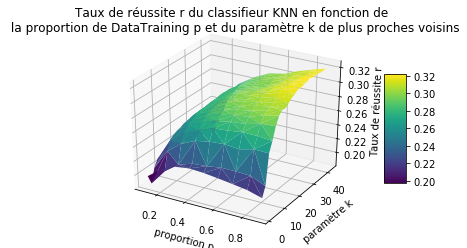

In [3]:
import matplotlib as mpl
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
 

x = np.array([ 0.1]*22 + [ 0.2]*22 + [ 0.3]*22+ [ 0.4]*22+ [ 0.5]*22+ [ 0.6]*22+ [ 0.7]*22+ [0.8]*22+ [ 0.9]*22)
print(x)
print(len(x))
y = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43]*9)
print(y)
print(len(y))
z = np.array(KNNResu)
print(z)
print(len(z))

fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title("Taux de réussite r du classifieur KNN en fonction de \n la proportion de DataTraining p et du paramètre k de plus proches voisins")
ax.set_xlabel('proportion p')
ax.set_ylabel('paramètre k')
ax.set_zlabel('Taux de réussite r')
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.savefig('CourbeKNNthiz.png')
plt.show()

# Rotate it
ax.view_init(30, 45)
plt.show()
 
# Other palette
ax.plot_trisurf(y, x, z, cmap=plt.cm.jet, linewidth=0.01)
plt.show()

## Détermination du maximum d'efficacité du KNN et des paramètres associés

In [8]:
zmax = 0
imax = 0
k = 0
for zi in z:
    k+=1
    if zi>zmax:
        zmax = zi
        imax = k
pmax = x[imax]
kmax = y[imax]
print ("Efficacité maximale du classifieur par KNN = " + str(zmax*100) + "%")
print("obtenue pour un paramètre de plus proches voisins k = " + str(kmax))
print("obtenue pour une proportion de DataTraining p = " + str(pmax))

Efficacité maximale du classifieur par KNN = 32.6%
obtenue pour un paramètre de plus proches voisins k = 33
obtenue pour une proportion de DataTraining p = 0.9


## CONCLUSION : Éfficacité du classifieur KNN maximale, de maximum 32.6% de réussite avec un paramètre de plus proches voisins k = 33 et une proportion de DataTraining p = 0.9

### NB : À noter qu'on considère être une réussite le fait de renvoyer exactement l'ambiance du texte. Les rapprochements d'ambiance ne sont pas pris en compte. Notamment, on ne pondère pas selon si la deuxième ambiance trouvée se rapproche de celle souhaitée. 